# Import Packages - Load Datasets 

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import googlemaps
import geopandas as gpd 
import re
# from datetime import time
# from datetime import date
# from dateutil import parser
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders import WOEEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest,f_regression

In [103]:
folder_path = "C:\KU Leuven\Modern Data Analytics - MDA\MDA Project\MDA\Raw Datasets from Toledo"
cad_9 = pd.read_parquet(f"{folder_path}\cad9.parquet.gzip", engine="pyarrow")
intvn1 = pd.read_parquet(f"{folder_path}\interventions1.parquet.gzip", engine="pyarrow")
intvn2 = pd.read_parquet(f"{folder_path}\interventions2.parquet.gzip", engine="pyarrow")
intvn3 = pd.read_parquet(f"{folder_path}\interventions3.parquet.gzip", engine="pyarrow")
bxl = pd.read_parquet(f"{folder_path}\interventions_bxl.parquet.gzip", engine="pyarrow")

# Merge Interventions - Include Distance using GeoPandas

In [104]:
subset_int1 = intvn1[["Mission ID",'Service Name',"Vector type",'Latitude permanence', 'Longitude permanence',"EventLevel Trip",'Latitude intervention', 'Longitude intervention',
                      "Province intervention","T0", "Intervention duration","Calculated Distance destination",'Abandon reason']]

subset_int2 = intvn2[["Mission ID",'Service Name',"Vector type",'Latitude permanence', 'Longitude permanence',"EventLevel Trip",'Latitude intervention', 'Longitude intervention',
                      "Province intervention","T0", "Intervention duration","Calculated Distance destination",'Abandon reason']]

subset_int3 = intvn3[["Mission ID",'Service Name',"Vector type",'Latitude permanence', 'Longitude permanence',"EventLevel Trip",'Latitude intervention', 'Longitude intervention',
                      "Province intervention","T0", "Intervention duration","Calculated Distance destination",'Abandon reason']]

bxl["province_intervention"] ="BXL"

subset_bxl = bxl[['mission_id','service_name',"vector_type",'latitude_permanence', 'longitude_permanence',"eventlevel_trip",'latitude_intervention', 'longitude_intervention',
                  "province_intervention","t0","intervention_duration","calculated_distance_destination_",'abandon_reason']]

subset_bxl.columns = subset_int1.columns

In [105]:
# string = '2022-09-06 00:49:21.5868598 +02:00'
def get_hour(string):
   new_string = string.split(" ")[1]
   if new_string.startswith("24"):
       new_string = new_string.replace("24","00")
   return int(new_string.split(":")[0])

subset_bxl["T0"] = subset_bxl["T0"].apply(get_hour)

def clean_t0(text):
    pattern = r'^[^:]+:'
    new_text = re.sub(pattern, '', text)
    if new_text.startswith("24"):
        new_text = new_text.replace("24","00")
    # new_text = pd.to_datetime(new_text, format='%H:%M:%S')
    return new_text

subset_int1["T0"] = subset_int1["T0"].apply(clean_t0)
subset_int2["T0"] = subset_int2["T0"].apply(clean_t0)
subset_int3["T0"] = subset_int3["T0"].apply(clean_t0)

subset_int1["T0"] = pd.to_datetime(subset_int1["T0"], format='%H:%M:%S')
subset_int2["T0"] = pd.to_datetime(subset_int2["T0"], format='%H:%M:%S')
subset_int3["T0"] = pd.to_datetime(subset_int3["T0"], format='%H:%M:%S')

subset_int1["T0"] = subset_int1["T0"].apply(lambda x: x.hour)
subset_int2["T0"] = subset_int2["T0"].apply(lambda x: x.hour)
subset_int3["T0"] = subset_int3["T0"].apply(lambda x: x.hour)
    

C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\693953402.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_bxl["T0"] = subset_bxl["T0"].apply(get_hour)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\693953402.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_int1["T0"] = subset_int1["T0"].apply(clean_t0)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\693953402.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

## Geopandas to calculate distance from Permanence-->Intervention

In [106]:
subset_bxl['geometry'] = gpd.points_from_xy(subset_bxl['Longitude intervention'], subset_bxl['Latitude intervention'])

subset_bxl_geo = gpd.GeoDataFrame(subset_bxl, 
                           crs = 'epsg:4326', # use the crs that the another geodataframe already uses
                           geometry = subset_bxl.geometry)


subset_bxl_geo['permanence_geometry'] = gpd.points_from_xy(subset_bxl_geo['Longitude permanence'], 
                                                             subset_bxl_geo['Latitude permanence'],
                                                             crs="EPSG:4326")

subset_bxl_geo["distance_to_intervention"] = subset_bxl_geo['geometry'].distance(other=subset_bxl_geo["permanence_geometry"])

subset_bxl = pd.DataFrame((subset_bxl_geo.drop(columns=['geometry','permanence_geometry'])))


C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\1466292713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_bxl['geometry'] = gpd.points_from_xy(subset_bxl['Longitude intervention'], subset_bxl['Latitude intervention'])
C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\1466292713.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  subset_bxl_geo["distance_to_intervention"] = subset_bxl_geo['geometry'].distance(other=subset_bxl_geo["permanence_geometry"])


In [107]:
subset_bxl.head()

,Mission ID,Service Name,Vector type,Latitude permanence,Longitude permanence,EventLevel Trip,Latitude intervention,Longitude intervention,Province intervention,T0,Intervention duration,Calculated Distance destination,Abandon reason,distance_to_intervention
0,20222490011,FB PDS BRUX [PASI CitÈ] SIAMU,Ambulance,5085097,436411,N5,5085139.0,436918.0,BXL,11,NaN,NaN,Error,5.087367e+02
1,20222490011,FB PDS BRUX [PASI CitÈ] SIAMU,Ambulance,5085097,436411,N5,5085139.0,436918.0,BXL,11,NaN,1330.0,None,5.087367e+02
2,20222490012,HB UR BRUX CHU St Pierre,Ambulance,508343302,43454504,N5,5083336.0,434504.0,BXL,11,NaN,NaN,Error,5.050954e+08
3,20222490015,FB PDS BRUX [PASI CitÈ] SIAMU,Ambulance,5085097,436411,N5,5085076.0,436359.0,BXL,12,17.0,NaN,Weigering van vervoer,5.608030e+01
4,20222490019,FB PDS WOLL [PASI UCL] SIAMU,Ambulance,5085211,44604,N5,508561.0,443169.0,BXL,13,NaN,NaN,Geannuleerd,4.593972e+06


In [108]:
# Create a geometry column in art
def create_geometry(dataset):

   dataset['geometry'] = gpd.points_from_xy(dataset['Longitude intervention'], dataset['Latitude intervention'])

# Create a GeoDataFrame from art and verify the type
   dataset_geo = gpd.GeoDataFrame(dataset, 
                           crs = 'epsg:4326', # use the crs that the another geodataframe already uses
                           geometry = dataset.geometry)
# print(type(interventions_geo))

   dataset_geo = dataset_geo.to_crs(3857)

   dataset_geo['permanence_geometry'] = gpd.points_from_xy(dataset_geo['Longitude permanence'], 
                                                             dataset_geo['Latitude permanence'],
                                                             crs="EPSG:4326")

   dataset_geo['permanence_geometry'] = dataset_geo['permanence_geometry'].to_crs(3857)

   dataset_geo["distance_to_intervention"] = dataset_geo['geometry'].distance(other=dataset_geo["permanence_geometry"])

   dataset_geo = pd.DataFrame((dataset_geo.drop(columns=['geometry','permanence_geometry'])))

   return dataset_geo

In [109]:
subset_int1 = create_geometry(subset_int1)
subset_int2 = create_geometry(subset_int2)
subset_int3 = create_geometry(subset_int3)

C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\1226707357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['geometry'] = gpd.points_from_xy(dataset['Longitude intervention'], dataset['Latitude intervention'])
c:\KU Leuven\Modern Data Analytics - MDA\MDA Project\.venv\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\1226707357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

## Merge into 1 dataset

In [110]:
interventions = pd.concat([subset_int1, subset_int2, subset_int3, subset_bxl], ignore_index=True)

interventions.shape[0] == subset_bxl.shape[0] + subset_int1.shape[0] + subset_int2.shape[0] + subset_int3.shape[0]

True

# General Preprocessing Pipeline (Class creation)

In [111]:
class preprocessing:
    def __init__(self, dataset):
        self.dataset = dataset[(dataset["Vector type"] != "Brandziekenwagen") & (dataset["Vector type"] != "Decontanimatieziekenwagen")] 
        self.dataset_2 = dataset[(interventions["Vector type"] != "Brandziekenwagen") & (dataset["Vector type"] != "Decontanimatieziekenwagen")] 
        self.vector_names = {('Ambulance Event','Ambulance Exceptional','Ambulance Disaster','Ambulance'):'Ambulance',
                    ('MUG Disaster','MUG Event','MUG'):'MUG',
                    ('PIT Disaster','PIT Event','PIT'):'PIT'}

        self.periods = {
           (8,9,10): 'morning',
           (11,12,13): 'noon',
           (14,15,16): 'afternoon',
           (17,18,19): 'evening',
           (20,21,22,23): 'night',
           (0,1,2,3,4,5,6,7): 'midnight'}
        


        self.rush_periods = {"morning":True,"noon":False,"afternoon":False,"evening":True,"night":False,"midnight":False}

        
        self.province_to_region = {('ANT','WVL','LIM'):"Vlaams Gewest",("BRW","HAI","LIE","LUX","NAM"):"Waals Gewest",("BXL"):"Brussel"}



    def preprocess(self):

        self.dataset["Vector type"] = self.dataset["Vector type"].apply(self.clean_ambulance)

        self.duplicates()

        self.dataset["Abandoned"] = self.dataset["Abandon reason"].apply(self.tranform_abandon)

        self.dataset.drop(["Latitude permanence","Longitude permanence","Latitude intervention","Longitude intervention","Abandon reason"],axis=1, inplace=True)
        self.dataset.dropna(inplace=True)

        self.dataset['time_period'] =  self.dataset['T0'].apply(self.map_to_period)

        self.dataset["rush_hour"] = self.dataset["time_period"].apply(self.time_to_rush)

        counts = self.dataset["EventLevel Trip"].value_counts()
        mask = self.dataset["EventLevel Trip"].isin(counts[counts < 190942].index)
        self.dataset["EventLevel Trip"][mask] = 'Other'

        self.dataset["Region"] = self.dataset["Province intervention"].apply(self.create_region)

        self.dataset["total_intervention_distance"] = self.dataset["distance_to_intervention"] + self.dataset["Calculated Distance destination"]

        enc = LabelEncoder()

        self.dataset["Abandoned"] = enc.fit_transform(self.dataset["Abandoned"])


        numeric_columns = self.dataset.select_dtypes(include=np.number)


        rows_with_infinite_values = self.dataset[~np.isfinite(numeric_columns).all(axis=1)]


        self.dataset = self.dataset.drop(rows_with_infinite_values.index)

        self.percentile_075 = np.percentile(self.dataset["Intervention duration"], 75)

        self.dataset["Risky"] = self.dataset["Intervention duration"].apply(self.binarize)

        return self.dataset


        

    def clean_ambulance(self,text):
        for key,value in self.vector_names.items():
            if text in key:
                return value
            
    def tranform_abandon(self,reason):
       if reason == "Error":
           return None
       elif reason == None:
           return False
       else:
            return True 
       
       
    def map_to_period(self,time):
       for period_range in self.periods.keys():
        if time in period_range:
            return self.periods[period_range]
        
    def time_to_rush(self,period):
        return self.rush_periods[period]
    
    def create_region(self,province_name):
       for names in self.province_to_region.keys():
           if province_name in names:
               return self.province_to_region[names]
           
    def duplicates(self):
        self.dataset.drop_duplicates(["Mission ID","Service Name","Vector type"], inplace=True)
        self.dataset = self.dataset.sort_values("Vector type", ascending=False)
        self.dataset.drop_duplicates(["Mission ID","Service Name"], keep="first", inplace=True)

    def missing_values_plot(self):
        missing_values = self.dataset_2.isna().sum() / self.dataset_2.shape[0]
        missing_values = missing_values.to_frame().reset_index()
        missing_values.columns = ["Feature","Missing"]
        
        plt.style.use("seaborn-v0_8")

        fig, ax = plt.subplots()

        ax.bar(missing_values["Feature"], missing_values["Missing"])

        ax.set_xticklabels(missing_values["Feature"], rotation=90)

        ax.set_title("Missing Values per Feature")
        ax.set_xlabel("Features")
        ax.set_ylabel("Percentage of Missing Values")


        plt.show()

    def event_level_plot(self):
        event_level = self.dataset_2["EventLevel Trip"].value_counts().to_frame().reset_index()
        event_level.columns = ["EventLevel","Count"]

        plt.style.use("seaborn-v0_8")

        fig, ax = plt.subplots()

        ax.bar(event_level["EventLevel"], event_level["Count"])

        ax.set_title("Event Level Counts")
        ax.set_xlabel("Event")
        ax.set_ylabel("Frequency")


        plt.show()

    def class_imbalance(self):
        safety_imbalance = self.dataset["Risky"].value_counts().to_frame().reset_index()

        plt.style.use("seaborn-v0_8")

        fig, ax = plt.subplots()

        ax.bar(safety_imbalance["Risky"], safety_imbalance["count"])

        ax.set_title("Class Imbalance")
        ax.set_xlabel("Risky")
        ax.set_ylabel("Frequency")
        ax.set_xticks([0, 1])
        # ax.set_ylim(0, 5000)


        plt.show()

    def binarize(self,value):
       if value < self.percentile_075:
           return 0
       else:
           return 1
        


In [112]:
preprocess_1 = preprocessing(interventions)

In [113]:
interventions = preprocess_1.preprocess()


C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\2691480367.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset["Vector type"] = self.dataset["Vector type"].apply(self.clean_ambulance)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\2691480367.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset.drop_duplicates(["Mission ID","Service Name","Vector type"], inplace=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\2691480367.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values 

C:\Users\Johnn\AppData\Local\Temp\ipykernel_28212\2691480367.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values["Feature"], rotation=90)


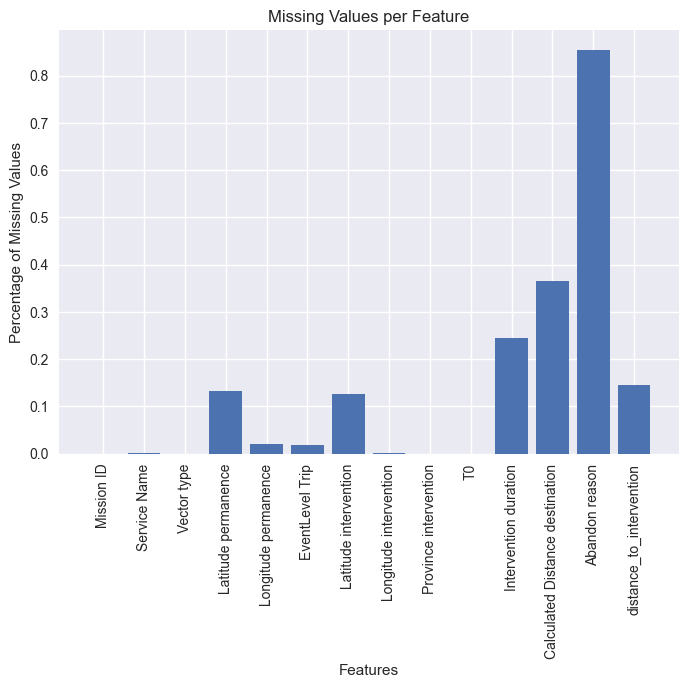

In [114]:
preprocess_1.missing_values_plot()

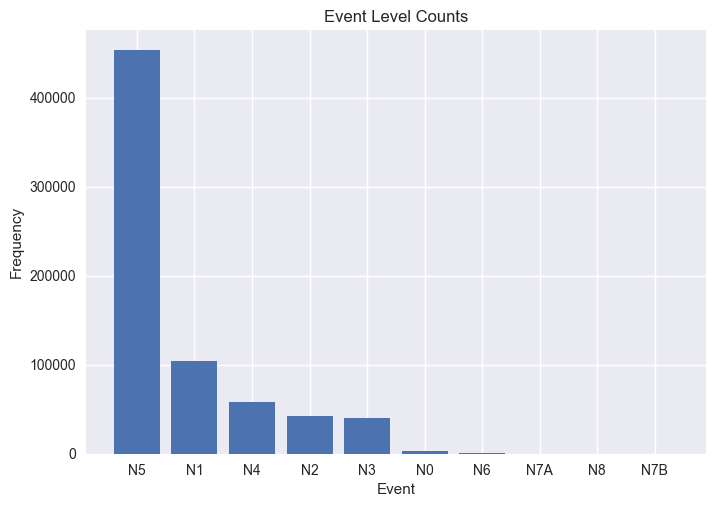

In [115]:
preprocess_1.event_level_plot()

In [116]:
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0


# Train-Test Split

In [117]:
X = interventions.drop("Risky", axis=1)
y = interventions["Risky"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [118]:
y.value_counts(normalize=True)

Risky
0    0.748944
1    0.251056
Name: proportion, dtype: float64

# Outliers

In [119]:
class outlier_handling:

    def __init__(self,dataset):
        self.dataset_train = dataset
        self.quant_columns  = self.dataset_train.select_dtypes(include=["int","float"]).drop(['Mission ID','Abandoned'],axis=1).columns
        

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Histograms of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].hist(self.dataset_train["T0"], bins="rice")
        ax[0, 1].hist(self.dataset_train["Intervention duration"], bins="rice")
        ax[1, 0].hist(self.dataset_train["Calculated Distance destination"], bins="rice")
        ax[1, 1].hist(self.dataset_train["distance_to_intervention"], bins="rice")
        ax[2, 0].hist(self.dataset_train["total_intervention_distance"], bins="rice")
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Boxplots of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].boxplot(self.dataset_train["T0"])
        ax[0, 1].boxplot(self.dataset_train["Intervention duration"])
        ax[1, 0].boxplot(self.dataset_train["Calculated Distance destination"])
        ax[1, 1].boxplot(self.dataset_train["distance_to_intervention"])
        ax[2, 0].boxplot(self.dataset_train["total_intervention_distance"])
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

    def describe_dataset(self,dataset):
        return dataset.describe()
        



    def truncate_outliers_train(self):
        for feature_name in self.quant_columns:
            self.median = np.median(self.dataset_train[feature_name])
            q75, q25 = np.percentile(self.dataset_train[feature_name], [75 ,25])
            iqr = q75-q25
            k = 3*iqr + self.median
            self.dataset_train[feature_name] = np.where((abs((self.dataset_train[feature_name]  - self.median) / iqr)) > 3, k, self.dataset_train[feature_name] )

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Histograms of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].hist(self.dataset_train["T0"], bins="rice")
        ax[0, 1].hist(self.dataset_train["Intervention duration"], bins="rice")
        ax[1, 0].hist(self.dataset_train["Calculated Distance destination"], bins="rice")
        ax[1, 1].hist(self.dataset_train["distance_to_intervention"], bins="rice")
        ax[2, 0].hist(self.dataset_train["total_intervention_distance"], bins="rice")
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Boxplots of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].boxplot(self.dataset_train["T0"])
        ax[0, 1].boxplot(self.dataset_train["Intervention duration"])
        ax[1, 0].boxplot(self.dataset_train["Calculated Distance destination"])
        ax[1, 1].boxplot(self.dataset_train["distance_to_intervention"])
        ax[2, 0].boxplot(self.dataset_train["total_intervention_distance"])
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

    def truncate_outliers_test(self, dataset_test):
        for feature_name in self.quant_columns:
            self.median = np.median(self.dataset_train[feature_name])
            q75, q25 = np.percentile(self.dataset_train[feature_name], [75 ,25])
            iqr = q75-q25
            k = 3*iqr + self.median
            dataset_test[feature_name] = np.where((abs((dataset_test[feature_name]  - self.median) / iqr)) > 3, k, dataset_test[feature_name] )

        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Boxplots of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].boxplot(dataset_test["T0"])
        ax[0, 1].boxplot(dataset_test["Intervention duration"])
        ax[1, 0].boxplot(dataset_test["Calculated Distance destination"])
        ax[1, 1].boxplot(dataset_test["distance_to_intervention"])
        ax[2, 0].boxplot(dataset_test["total_intervention_distance"])
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()



   


        


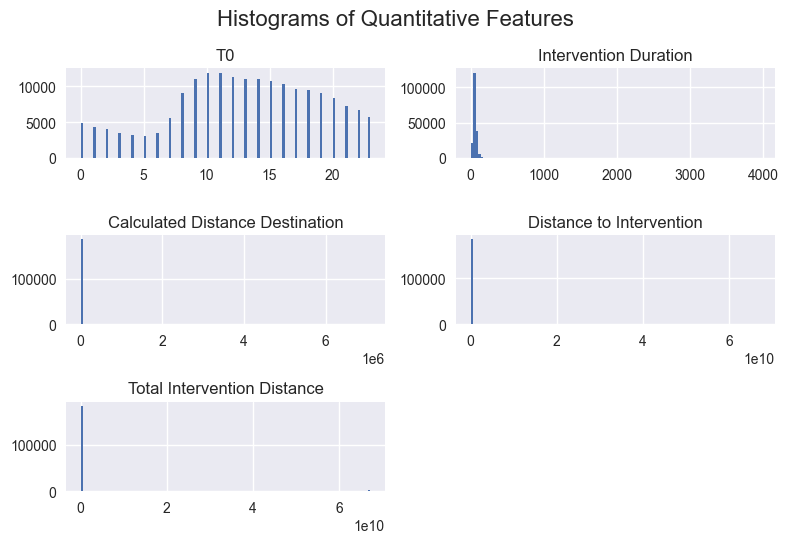

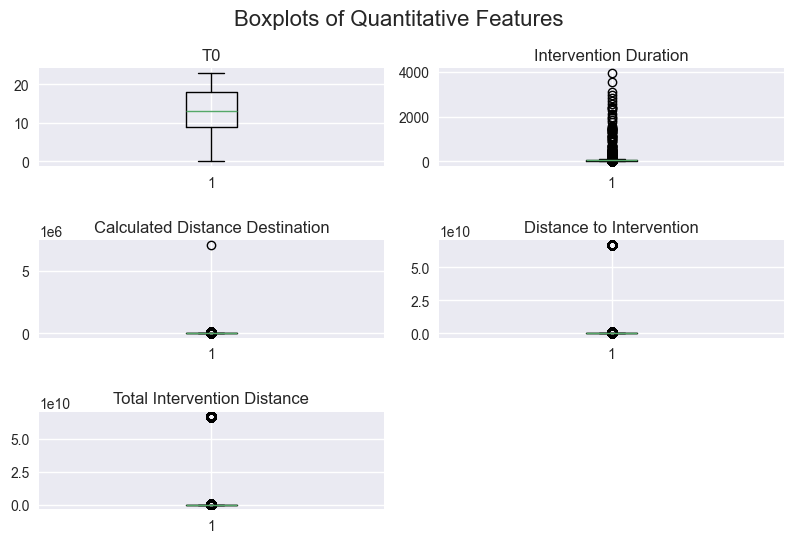

In [120]:
outlier = outlier_handling(X_train)

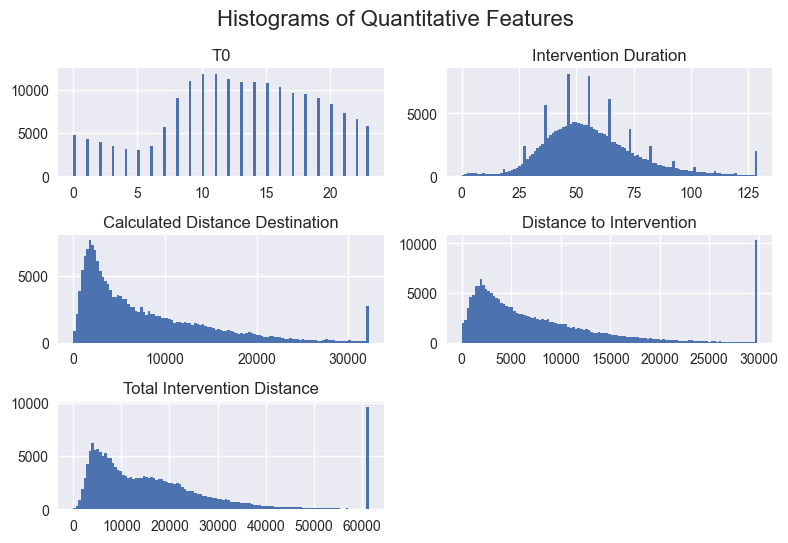

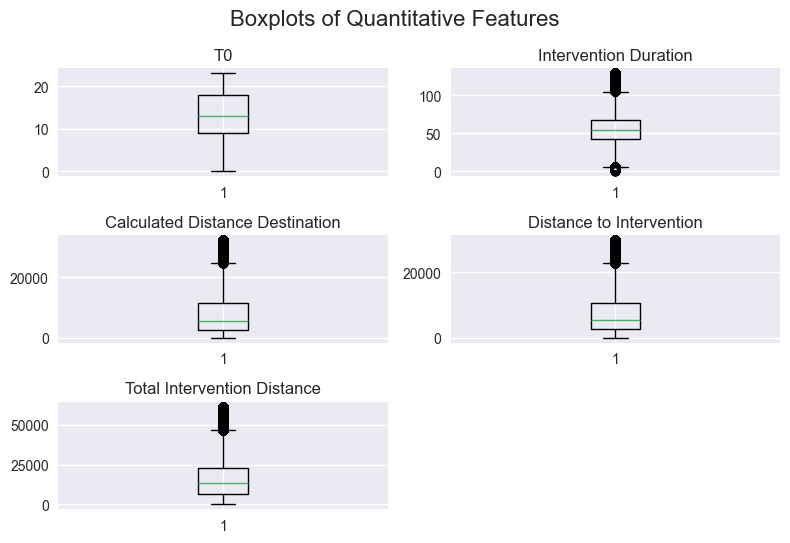

In [121]:
outlier.truncate_outliers_train()

In [122]:
outlier.describe_dataset(X_test)

,Mission ID,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,total_intervention_distance
count,7.978600e+04,79786.000000,79786.000000,79786.000000,7.978600e+04,79786.000000,7.978600e+04
mean,4.623268e+10,12.833931,57.233337,8036.176861,6.347796e+08,0.000175,6.347877e+08
std,2.671910e+10,5.898017,37.548137,7725.931806,6.459208e+09,0.013245,6.459208e+09
min,1.022152e+10,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,2.022363e+10,9.000000,43.000000,2463.000000,2.619095e+03,0.000000,6.689467e+03
50%,5.022352e+10,13.000000,54.000000,5454.500000,5.551779e+03,0.000000,1.350092e+04
75%,7.022155e+10,17.000000,68.000000,11390.500000,1.076206e+04,0.000000,2.271199e+04
max,9.023091e+10,23.000000,5049.000000,109654.000000,6.721171e+10,1.000000,6.721172e+10


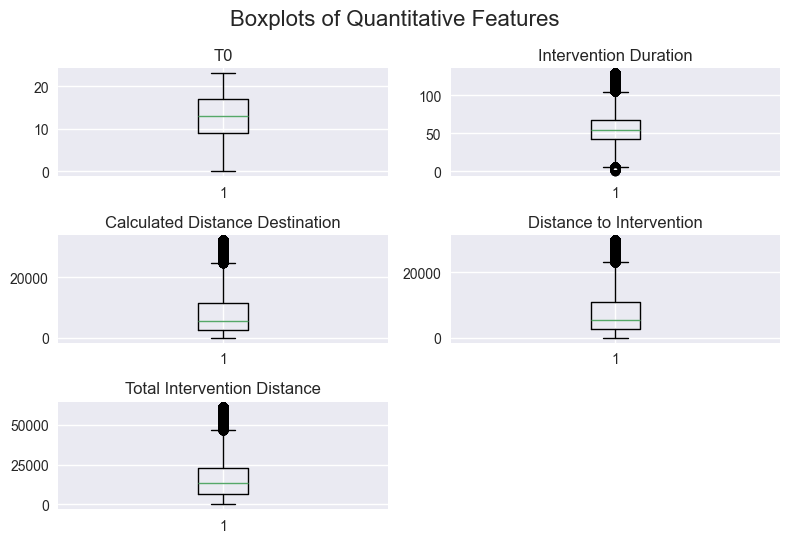

In [123]:
outlier.truncate_outliers_test(X_test)

# Class Imbalance 

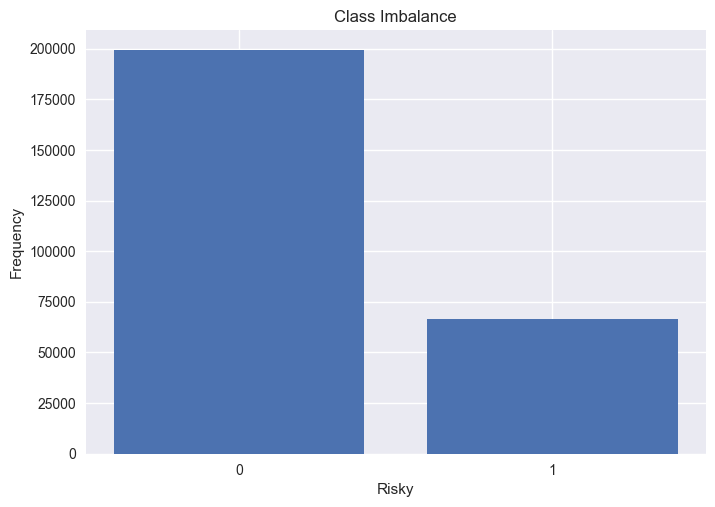

In [124]:
preprocess_1.class_imbalance()

In [125]:
interventions["Risky"].value_counts(normalize=True)

Risky
0    0.748944
1    0.251056
Name: proportion, dtype: float64

In [303]:
class logistic:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        self.columns_to_drop=["Mission ID", "Service Name","total_intervention_distance","Region","Intervention duration"]
        self.one_hot_encode_columns=["Vector type","rush_hour","EventLevel Trip"]
        self.woe_encode_columns=["Province intervention","time_period"]
        self.standard_columns = ["distance_to_intervention","Calculated Distance destination","T0"]

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('drop_columns', 'drop', self.columns_to_drop),
                ('one_hot_encode', OneHotEncoder(drop='first'), self.one_hot_encode_columns),
                ('WOE_encode', WOEEncoder(), self.woe_encode_columns),
                ('standardize', StandardScaler(), self.standard_columns)
            ],
            remainder='passthrough'
        )  

        self.interventions_train = self.preprocessor.fit_transform(self.X_train,self.y_train)
        self.interventions_train = pd.DataFrame(self.interventions_train, columns=self.preprocessor.get_feature_names_out())

        self.interventions_test = self.preprocessor.transform(self.X_test)
        self.interventions_test = pd.DataFrame(self.interventions_test, columns=self.preprocessor.get_feature_names_out())

    def preprocessor(self):
        return self.preprocessor


    def intervention_sets_logistic(self):
        return (self.interventions_train, self.interventions_test)

    def correlation_map(self):

        plt.figure()

        heatmap = sns.heatmap(self.interventions_train.corr(), vmin=-1, vmax=1, annot=True)

        heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

    def ridge_logistic(self):
        lr = LogisticRegression(random_state=8) 

        param_grid = {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=5)
        # Instantiate the GridSearchCV object and run the search
        # The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
        searcher = GridSearchCV(lr, param_grid, cv=kf, scoring="precision")
        searcher.fit(self.interventions_train, self.y_train)

        self.lr_best = searcher.best_estimator_
        self.lr_best.fit(self.interventions_train,self.y_train)

        self.roc_auc_score_ridge = roc_auc_score(self.y_test, self.lr_best.predict_proba(self.interventions_test)[:,1])
        self.accuracy_ridge = accuracy_score(self.y_test, self.lr_best.predict(self.interventions_test))
        self.precision_ridge = precision_score(self.y_test, self.lr_best.predict(self.interventions_test))

        return self.lr_best
    
    def roc_ridge(self):

        #Generate ROC curve values: fpr, tpr, thresholds
        self.fpr_1, self.tpr_1, thresholds = roc_curve(self.y_test, self.lr_best.predict_proba(self.interventions_test)[:,1])

        plt.plot([0, 1], [0, 1], 'k--')

        # Plot tpr against fpr
        plt.plot(self.fpr_1, self.tpr_1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Ridge')
        plt.show()

        # Calculate roc_auc_score
        print(f"The roc_auc score is: {self.roc_auc_score_ridge}")
        print(f"The accuracy score is: {self.accuracy_ridge}")
        print(f"The precision score is: {self.precision_ridge}")

    def lasso_logistic(self):
        lr = LogisticRegression(solver='liblinear', penalty="l1",random_state=8) 

        param_grid = {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=5)

        # Instantiate the GridSearchCV object and run the search
        # The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
        searcher_lasso = GridSearchCV(lr, param_grid, cv=kf, scoring="precision")
        searcher_lasso.fit(self.interventions_train, self.y_train)

        self.best_model_lr = searcher_lasso.best_estimator_
        self.best_model_lr.fit(self.interventions_train,self.y_train)

        self.roc_auc_score_lasso = roc_auc_score(self.y_test, self.best_model_lr.predict_proba(self.interventions_test)[:,1])
        self.accuracy_lasso = accuracy_score(self.y_test, self.best_model_lr.predict(self.interventions_test))
        self.precision_lasso = precision_score(self.y_test, self.best_model_lr.predict(self.interventions_test))

        return self.best_model_lr
    
    def roc_lasso(self):

        #Generate ROC curve values: fpr, tpr, thresholds
        self.fpr_2, self.tpr_2, thresholds = roc_curve(self.y_test, self.best_model_lr.predict_proba(self.interventions_test)[:,1])

        plt.plot([0, 1], [0, 1], 'k--')

        # Plot tpr against fpr
        plt.plot(self.fpr_2, self.tpr_2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Lasso')
        plt.show()

        print(f"The roc_auc score is: {self.roc_auc_score_lasso}")
        print(f"The accuracy score is: {self.accuracy_lasso}")
        print(f"The precision score is: {self.precision_lasso}")

    def k_best(self):
        lr_k_best = LogisticRegression(random_state=9, max_iter=1000)

        pipeline = Pipeline(
            [
            ('selector',SelectKBest(f_regression)),
            ('model',lr_k_best)
            ]
        )

        param_grid = {
            'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'selector__k' : [1,2,3,4,5,6,7,8,9,10]

        }

        kf = KFold(n_splits=5, shuffle=True, random_state=5)

        # kf = KFold(n_splits=5, shuffle=True, random_state=5)

        # Instantiate the GridSearchCV object and run the search
        # The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
        searcher_k_best = GridSearchCV(pipeline, param_grid, cv=kf, scoring="precision")
        searcher_k_best.fit(self.interventions_train, self.y_train)

        mask_k_best = searcher_k_best.best_estimator_.named_steps['selector'].get_support()

        self.reduced_train_k_best = self.interventions_train.loc[:,mask_k_best]
        self.reduced_test_k_best = self.interventions_test.loc[:,mask_k_best]

        self.lr_kbest = searcher_k_best.best_estimator_
        self.lr_kbest.fit(self.reduced_train_k_best,y_train)

        self.roc_auc_score_kbest = roc_auc_score(self.y_test, self.lr_kbest.predict_proba(self.reduced_test_k_best)[:,1])
        self.accuracy_kbest = accuracy_score(self.y_test, self.lr_kbest.predict(self.reduced_test_k_best))
        self.precision_kbest = precision_score(self.y_test, self.lr_kbest.predict(self.reduced_test_k_best))

        return (self.lr_kbest, self.reduced_train_k_best.columns)
    
    def roc_k_best(self):

        self.fpr_3, self.tpr_3, thresholds = roc_curve(self.y_test, self.lr_kbest.predict_proba(self.reduced_test_k_best)[:,1])

        plt.plot([0, 1], [0, 1], 'k--')

        # Plot tpr against fpr
        plt.plot(self.fpr_3, self.tpr_3)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - K-Best')
        plt.show()

        # Calculate roc_auc_score
        print(f"The roc_auc score is: {self.roc_auc_score_kbest}")
        print(f"The accuracy score is: {self.accuracy_kbest}")
        print(f"The precision score is: {self.precision_kbest}")

    def random_forest(self):
        
        columns_to_drop_2=["Mission ID", "Service Name","total_intervention_distance","Region","Intervention duration"]
        one_hot_encode_columns_2=["Vector type","rush_hour","EventLevel Trip"]
        woe_encode_columns_2=["Province intervention","time_period"]
        # standard_columns = ["distance_to_intervention","Calculated Distance destination","T0"]

        preprocessor_2 = ColumnTransformer(
        transformers=[
            ('drop_columns', 'drop', columns_to_drop_2),
            ('one_hot_encode', OneHotEncoder(drop='first'), one_hot_encode_columns_2),
            ('WOE_encode', WOEEncoder(), woe_encode_columns_2),
            # ('standardize', StandardScaler(), standard_columns)
        ],
        remainder='passthrough'
            )  
        
        self.interventions_train_random = preprocessor_2.fit_transform(self.X_train,self.y_train)
        self.interventions_train_random = pd.DataFrame(self.interventions_train_random, columns=preprocessor_2.get_feature_names_out())

        self.interventions_test_random = preprocessor_2.transform(self.X_test)
        self.interventions_test_random = pd.DataFrame(self.interventions_test_random, columns=preprocessor_2.get_feature_names_out())

        random_f = RandomForestClassifier(bootstrap=True,random_state=7)

        grid_param = {
            "n_estimators" : [50,70,100,120,150],
            'criterion': ['gini','entropy'],
            'max_features' : [1,2,"log2"],
            'class_weight' : ["balanced", "balanced_subsample"]
        }

        kf = KFold(n_splits=5, shuffle=True, random_state=5)


        random_searcher = RandomizedSearchCV(random_f, grid_param, cv=kf,scoring="precision", random_state=33)
        random_searcher.fit(self.interventions_train_random, self.y_train)

        self.random_f_best = random_searcher.best_estimator_

        self.random_f_best.fit(self.interventions_train_random,self.y_train)

        self.roc_auc_score_random = roc_auc_score(self.y_test, self.random_f_best.predict_proba(self.interventions_test_random)[:,1])
        self.accuracy_random = accuracy_score(self.y_test, self.random_f_best.predict(self.interventions_test_random))
        self.precision_random = precision_score(self.y_test, self.random_f_best.predict(self.interventions_test_random))

        return self.random_f_best
    
    def interventions_set_random(self):
        return (self.interventions_train_random, self.interventions_test_random)

    
    def roc_random(self):

        self.fpr_4, self.tpr_4, thresholds = roc_curve(self.y_test, self.random_f_best.predict_proba(self.interventions_test_random)[:,1])

        plt.plot([0, 1], [0, 1], 'k--')

        # Plot tpr against fpr
        plt.plot(self.fpr_4, self.tpr_4)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Random Forest')
        plt.show()

        # Calculate roc_auc_score
        print(f"The roc_auc score is: {self.roc_auc_score_random}")
        print(f"The accuracy score is: {self.accuracy_random}")
        print(f"The precision score is: {self.precision_random}")


    def feature_importance_random(self):
        
        diction = {key: value for key, value in zip(self.interventions_test_random.columns.values, self.random_f_best.feature_importances_)}
        sorted_dict = dict(sorted(diction.items(), key=lambda item: item[1], reverse=True))

        sns.barplot(x=list(sorted_dict.values()),y=list(sorted_dict.keys()),color="red")


    


    def compare_models(self):

        plt.plot([0, 1], [0, 1], 'k--')

        # Plot tpr against fpr
        plt.plot(self.fpr_1, self.tpr_1,label='Ridge Logistic', color='blue')
        plt.plot(self.fpr_2, self.tpr_2,label='Lasso Logistic', color='red')
        plt.plot(self.fpr_3, self.tpr_3,label='K-Best Logistic', color='green')
        plt.plot(self.fpr_4, self.tpr_4,label='Random Forest', color='purple')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Logistic VS Random Forest')
        plt.legend()
        plt.show()
        

In [304]:
logistic_regression = logistic(X_train,y_train,X_test,y_test)

In [305]:
interventions_train, interventions_test = logistic_regression.intervention_sets_logistic()

In [306]:
logistic_regression.lasso_logistic()

LogisticRegression(C=0.001, penalty='l1', random_state=8, solver='liblinear')

In [307]:
logistic_regression.ridge_logistic()

LogisticRegression(C=0.001, random_state=8)

In [308]:
model_k, features_number = logistic_regression.k_best()
model_k

Pipeline(steps=[('selector',
                 SelectKBest(k=9,
                             score_func=<function f_regression at 0x00000230AF408F40>)),
                ('model',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=9))])

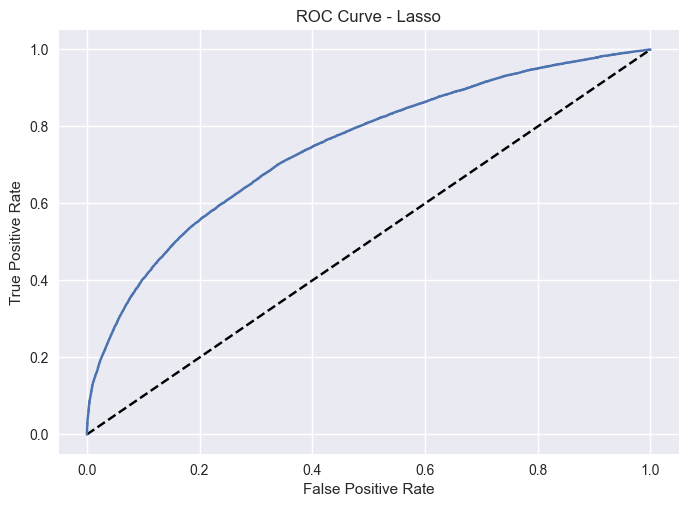

The roc_auc score is: 0.7463291545832185
The accuracy score is: 0.7816283558519038
The precision score is: 0.6643559364759264


In [309]:
logistic_regression.roc_lasso()

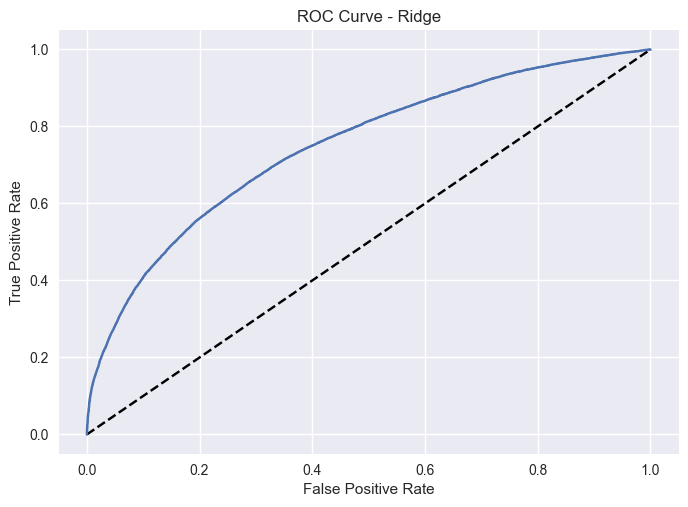

The roc_auc score is: 0.7492366824727671
The accuracy score is: 0.7824179680645728
The precision score is: 0.6666666666666666


In [260]:
logistic_regression.roc_ridge()

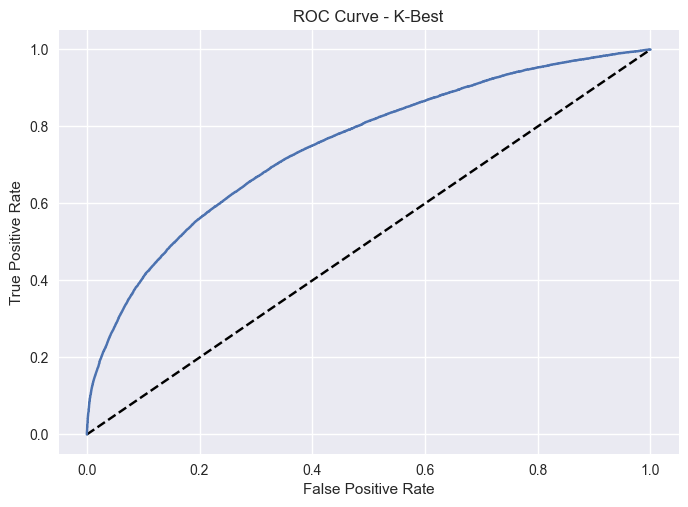

The roc_auc score is: 0.749236662839572
The accuracy score is: 0.7824179680645728
The precision score is: 0.6666666666666666


In [261]:
logistic_regression.roc_k_best()

In [262]:
random_best = logistic_regression.random_forest()
random_best


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=120, random_state=7)

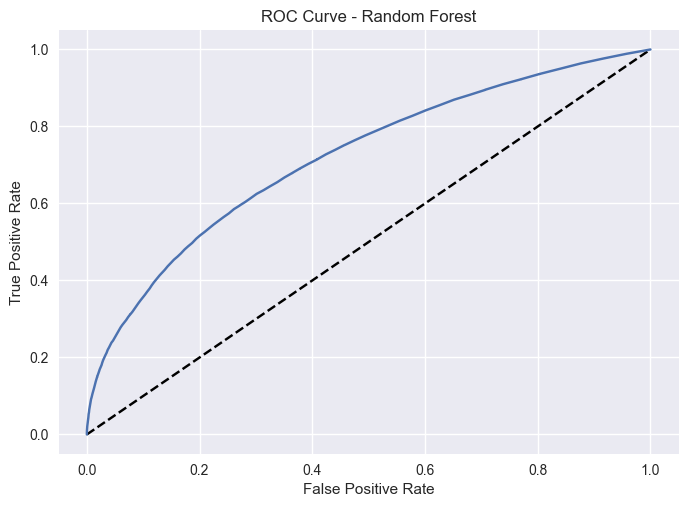

The roc_auc score is: 0.7195998056413947
The accuracy score is: 0.7650464993858571
The precision score is: 0.5506823380926087


In [263]:
logistic_regression.roc_random()

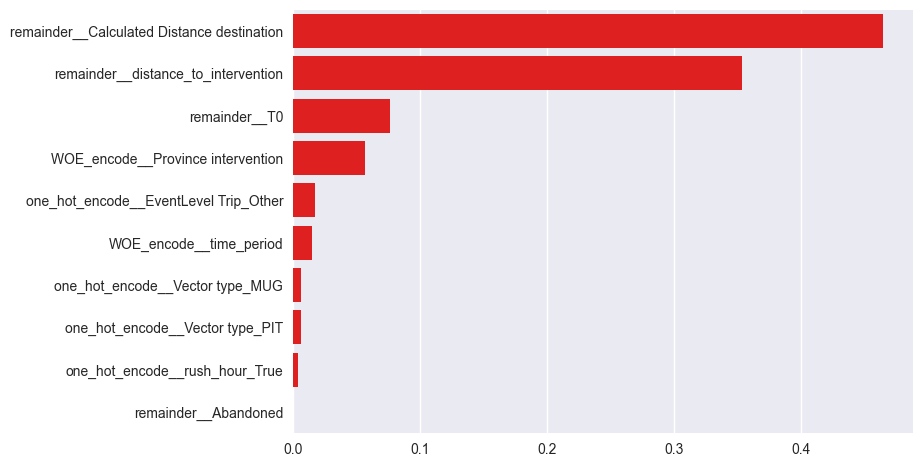

In [264]:
logistic_regression.feature_importance_random()

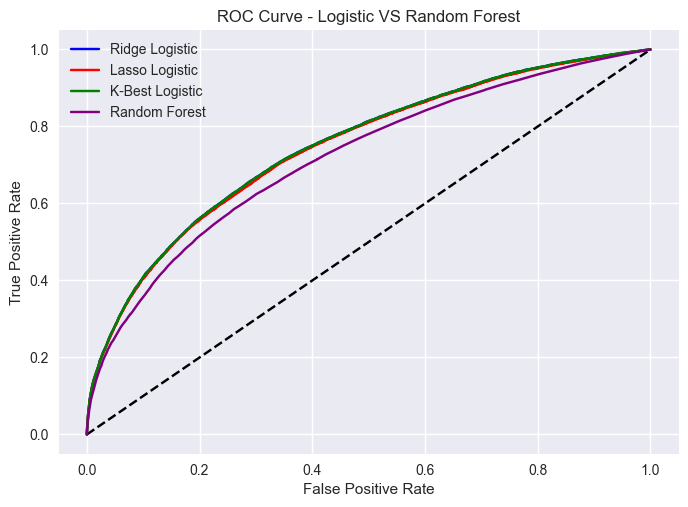

In [265]:
logistic_regression.compare_models()

In [267]:
interventions_train_random, interventions_test_random = logistic_regression.interventions_set_random()

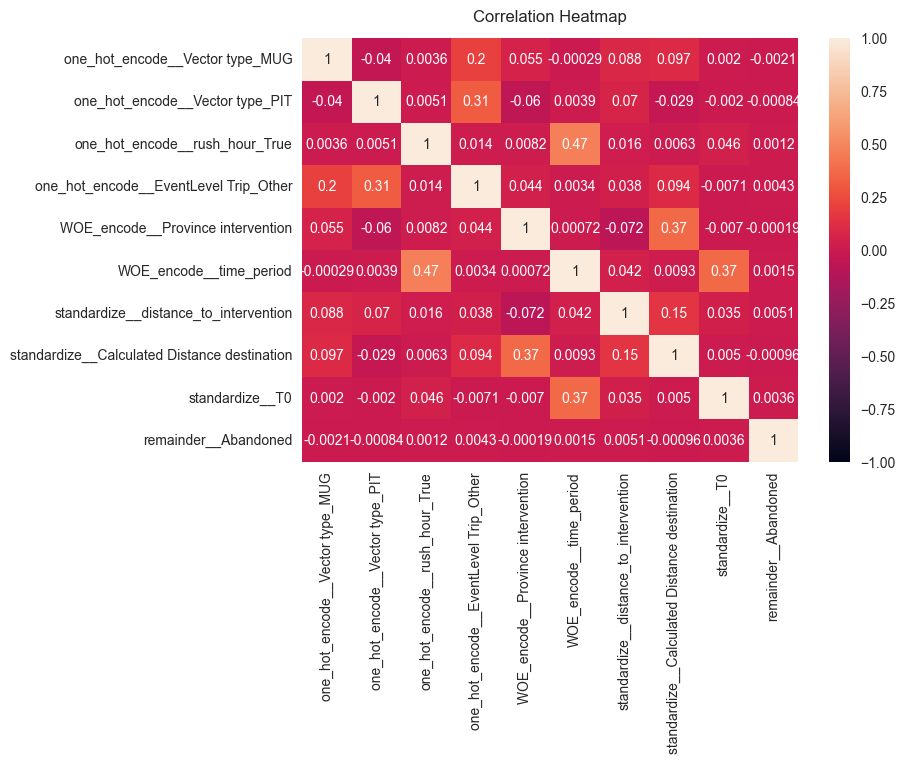

In [268]:
logistic_regression.correlation_map()

In [269]:
interventions_train_random.columns

Index(['one_hot_encode__Vector type_MUG', 'one_hot_encode__Vector type_PIT',
       'one_hot_encode__rush_hour_True',
       'one_hot_encode__EventLevel Trip_Other',
       'WOE_encode__Province intervention', 'WOE_encode__time_period',
       'remainder__T0', 'remainder__Calculated Distance destination',
       'remainder__distance_to_intervention', 'remainder__Abandoned'],
      dtype='object')

In [270]:
subset_train_import = interventions_train_random[['remainder__Calculated Distance destination',
                                           'remainder__distance_to_intervention',
                                           'remainder__T0',
                                           'WOE_encode__Province intervention',
                                           'one_hot_encode__EventLevel Trip_Other']]

subset_test_import = interventions_test_random[['remainder__Calculated Distance destination',
                                           'remainder__distance_to_intervention',
                                           'remainder__T0',
                                           'WOE_encode__Province intervention',
                                           'one_hot_encode__EventLevel Trip_Other']]

In [271]:
random_best.fit(subset_train_import ,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=120, random_state=7)

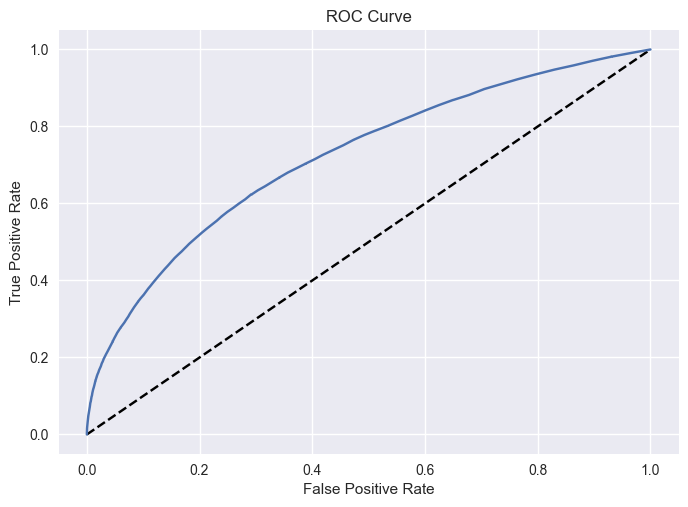

0.7218855661182284
[[54525  5230]
 [13267  6764]]
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     59755
           1       0.56      0.34      0.42     20031

    accuracy                           0.77     79786
   macro avg       0.68      0.63      0.64     79786
weighted avg       0.74      0.77      0.75     79786



In [272]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_best.predict_proba(subset_test_import)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_best.predict_proba(subset_test_import)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_best.predict(subset_test_import)))

# Calculate the classification report
print(classification_report(y_test, random_best.predict(subset_test_import)))

In [273]:
accuracy_score(y_test, random_best.predict(subset_test_import))

0.7681673476549771

In [340]:
model_lr = logistic_regression.lasso_logistic()

In [341]:
model_lr.classes_

array([0, 1], dtype=int64)

In [343]:
model_lr.fit(interventions_train,y_train)

LogisticRegression(C=0.001, penalty='l1', random_state=8, solver='liblinear')

In [345]:

coefficients = model_lr.coef_.reshape(10,)
feature_coeff = dict(zip(list(interventions_train.columns), list(coefficients)))
feature_coeff = dict(sorted(feature_coeff.items(), key=lambda item: item[1], reverse=True))
feature_coeff

{'standardize__Calculated Distance destination': 0.7599922765569684,
 'one_hot_encode__EventLevel Trip_Other': 0.46168511448438454,
 'standardize__distance_to_intervention': 0.21981265849951984,
 'one_hot_encode__Vector type_MUG': 0.0,
 'one_hot_encode__Vector type_PIT': 0.0,
 'one_hot_encode__rush_hour_True': 0.0,
 'WOE_encode__Province intervention': 0.0,
 'WOE_encode__time_period': 0.0,
 'standardize__T0': 0.0,
 'remainder__Abandoned': 0.0}

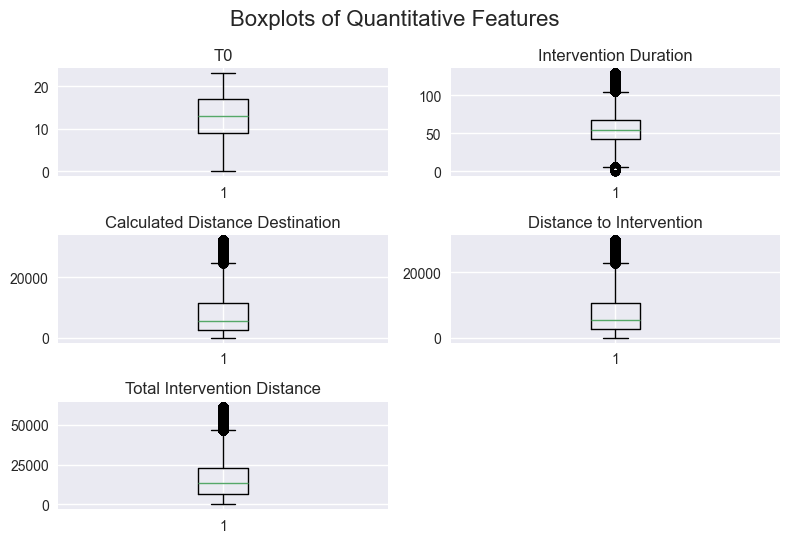

In [346]:
outlier.truncate_outliers_test(X)

In [347]:
preprocessor = logistic_regression.preprocessor

In [348]:
interventions_preprocessed = preprocessor.transform(X)
interventions_preprocessed = pd.DataFrame(interventions_preprocessed, columns=preprocessor.get_feature_names_out())
interventions_preprocessed

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,standardize__distance_to_intervention,standardize__Calculated Distance destination,standardize__T0,remainder__Abandoned
0,0.0,1.0,1.0,0.0,-0.394921,0.028318,-0.332054,-0.913587,-0.484605,0.0
1,0.0,1.0,1.0,0.0,-0.394921,0.028318,-0.889282,-0.839396,-0.653846,0.0
2,0.0,1.0,1.0,1.0,-0.394921,0.042188,-0.390085,-0.796598,0.869325,0.0
3,0.0,1.0,0.0,1.0,-0.160709,-0.025483,-0.567854,-0.477728,-0.315364,0.0
4,0.0,1.0,0.0,1.0,0.245206,0.072329,0.031033,0.194362,0.361601,0.0
...,...,...,...,...,...,...,...,...,...,...
265948,0.0,0.0,0.0,1.0,-0.025579,-0.025483,-0.824126,-1.108851,-0.146122,0.0
265949,0.0,0.0,0.0,0.0,-0.025579,-0.025483,-0.178040,-0.745354,-0.146122,0.0
265950,0.0,0.0,0.0,0.0,-0.025579,-0.025483,0.852073,0.045556,-0.146122,0.0
265951,0.0,0.0,0.0,0.0,-0.025579,-0.025483,1.959740,-0.725503,0.023119,0.0


In [350]:
interventions["Probability_Risk"] = model_lr.predict_proba(interventions_preprocessed)[:,1]
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky,Probability_Risk
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1,0.109268
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0,0.102999
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0,0.173590
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1,0.204706
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0,0.328559


In [351]:
interventions.groupby("Province intervention")["Probability_Risk"].mean()

Province intervention
ANT    0.231059
BRW    0.271696
BXL    0.170976
HAI    0.244601
LIE    0.238845
LIM    0.304816
LUX    0.415180
NAM    0.333611
Name: Probability_Risk, dtype: float64

In [352]:
interventions.groupby("Region")["Probability_Risk"].mean()

Region
Brussel          0.170976
Vlaams Gewest    0.256476
Waals Gewest     0.275259
Name: Probability_Risk, dtype: float64

In [358]:
interventions.to_csv('C:\KU Leuven\Modern Data Analytics - MDA\MDA Project\MDA\Created CSV Files\Interventions_risky_probability.csv', index=False)

# Linear Model

In [ ]:
columns_to_drop=["Mission ID", "Service Name","total_intervention_distance","Region","Abandoned"]
one_hot_encode_columns=["Vector type","rush_hour","EventLevel Trip"]
# woe_encode_columns=["Province intervention"]
standard_columns = ["T0","distance_to_intervention","Calculated Distance destination","Intervention duration"]

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first'), one_hot_encode_columns),
        # ('WOE_encode', WOEEncoder(), woe_encode_columns),
        ('standardize', StandardScaler(), standard_columns)
    ],
    remainder='passthrough'
  )  